In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import gmsh
import cv2
import scipy
import matplotlib as mpl
import plotly.graph_objs as go

from sklearn.neighbors import KNeighborsClassifier

In [2]:
# weights and points for Gauss Quadrature 
points = {1:[0] ,2:[1/(3**0.5),-1/(3**0.5)],3:[(3/5)**.5,0,-(3/5)**.5]}
weights = {1:[2],2:[1,1],3:[5/9,8/9,5/9]}
points_2D = {1:[[1/3,1/3]],3:[[1/6,1/6],[2/3,1/6],[1/6,2/3]]}
weights_2D = {1:[.5],3:[1/6,1/6,1/6]}

In [3]:
qo = 0   # W/mm^2
# Cp = 658 #J/kg.K
# rho = 7.6e-6 #kg/mm^3
# kappa = 0.025 #W/mm.K
ro = 2 #mm
vo = 0 #mm/s
Q = 5 #W/mm2

In [4]:
def rho(T):
    return 7*1e-6

def Cp(T):
    return 465
    
def Kappa(T):
    return (100 + .004*(T-50)**2)**1e-3

In [5]:
def Gaussian(X):
    return 15*(X[0]/100)*(1-(X[0]/100))*(1e-3)
def NeumannBoundaryCondition(x,y):
    return qo

In [6]:
#################
### Workhorse ###
#################
class RectangularMesh:
    '''Class specific to IITM mesh'''
    def __init__(self, mesh_factor,geo_file,values) -> None:
        self.createMesh(mesh_factor,geo_file)
        self.Temperature = (np.ones((1,len(self.coords)))*values).T
        self.M,self.A,self.K,self.S = self.Create_Matrices_2D()
        self.Boundary = self.CreateNeumannBCMAtrix()
           
    def createMesh(self,mesh_factor,geo_file):
        '''Create Mesh File'''
        import gmsh
        gmsh.initialize()
        gmsh.open(geo_file)
        gmsh.option.setNumber("Mesh.MeshSizeFactor", mesh_factor)
        gmsh.model.mesh.generate(2)
        mesh_filename = 'Square.msh'
        gmsh.write(mesh_filename)
        gmsh.finalize()
        self.mshInfo(meshInfo=mesh_filename)

    def mshInfo(self,meshInfo):
        '''extracing mesh info from mesh file'''
        import gmsh
        gmsh.initialize()
        #inorder to read the .msh file replace string "IITM_MAP_coarse.msh" with the address of IITM_MAP_coarse.msh
        'Change the location correwspondingly'
        gmsh.open(meshInfo)
        # Extracting nodes from msh file
        nodeTags,coords,parametricCoord = gmsh.model.mesh.getNodes(-1)     
        coords = coords.reshape((-1,3))
        self.coords = coords[:,:2]
        # Extracting boundary mesh elements from msh file
        _, self.linearNodesTags = gmsh.model.mesh.getElementsByType(1,-1)
        self.linearNodes = np.unique(self.linearNodesTags)
        self.linearNodesTags = self.linearNodesTags.reshape(-1,2)
        # Extracting triangular mesh elements from msh file
        eleTags, triNodesTags = gmsh.model.mesh.getElementsByType(2,-1)
        self.triNodesTags = triNodesTags.reshape((-1,3))
        gmsh.finalize()

    def Create_Matrices_2D(self):
        triNodesTags = self.triNodesTags
        coords = self.coords
        Temp = self.Temperature
        # print(coords.shape)
        # print(coords[0])
        n = len(coords)
        gaussPoints = 3
        sigma = ro
        mu = np.array([50,25])
        A = np.zeros((n,n))
        M = np.zeros((n,n))
        K = np.zeros((n,n))
        F = np.zeros((n,1))
        for ele in range(len(triNodesTags)):
            coordinates = coords[triNodesTags[ele]-1].T           #coordinates is dim * no. of points matrix
            Temperature = Temp[triNodesTags[ele]-1].reshape(-1,1)
            rho_cp_element = 1
            for gpts in range(gaussPoints):
                pt = points_2D[gaussPoints][gpts]
                N = np.array([1-pt[0]-pt[1], pt[0], pt[1]]).reshape(1,-1)
                
                dN = np.array([[-1,1,0],[-1,0,1]]).T        #grad phi
                k_element = Kappa((N@Temperature)[0][0])                          # thermal conductivity
                rho_cp = rho((N@Temperature)[0][0]) * Cp((N@Temperature)[0][0])     # density * heat capacity 
                # print(rho_cp)        
                Jac_T = coordinates @ dN
                Jac_T_inv = np.linalg.inv(Jac_T)
                det_jac = np.linalg.det(Jac_T)
                m = (N.T@N)*det_jac*weights_2D[gaussPoints][gpts]*rho_cp
                # print((Jac_T_inv@dN).shape)
                temp = (dN@Jac_T_inv)[:,0].reshape(-1,1)
                k = rho_cp*vo*(N.T@temp.T)*det_jac*weights_2D[gaussPoints][gpts]

                a = (dN@Jac_T_inv)@((dN@Jac_T_inv).T)*det_jac*weights_2D[gaussPoints][gpts]*k_element
                X = (coordinates @ N.T).reshape(-1)
                # print([triNodesTags[ele]-1])
                f = N.T*Gaussian(X)*det_jac*weights_2D[gaussPoints][gpts]
                K[np.ix_(triNodesTags[ele]-1,triNodesTags[ele]-1)] += k
                M[np.ix_(triNodesTags[ele]-1,triNodesTags[ele]-1)] += m
                A[np.ix_(triNodesTags[ele]-1,triNodesTags[ele]-1)] += a
                F[triNodesTags[ele]-1] += f.reshape(-1,1)
        return M,A,K,F
    
    def CreateNeumannBCMAtrix(self):
        linearNodes = self.linearNodesTags
        coords = self.coords
        # print(coords.shape)
        n = self.S.shape[0]
        Boundary = np.zeros((n,1))
        gaussPoints = 3
        for ele in range(len(linearNodes)):
            coordinates = coords[linearNodes[ele]-1].T 
            for pt in range(len(points[gaussPoints])):
                N = np.array([(1-points[gaussPoints][pt])/2,(1+points[gaussPoints][pt])/2]).reshape(1,-1)
                dN = np.array([-0.5,0.5]).T
                Jac_T = coordinates@dN
                det_Jac = np.linalg.norm(Jac_T)
                x = N@coordinates[0,:]
                y = N@coordinates[1,:]
                b = N.T*NeumannBoundaryCondition(x[0],y[0])*weights[gaussPoints][pt]*det_Jac
                Boundary[linearNodes[ele]-1] += b
        return Boundary

In [7]:
def PicardIteration(mesh_size_factor):
    '''Function to perform Picard Iteration'''

    ## Initialisation
    delta_t = .1
    T = 10
    steps = int(T/delta_t)
    tol = 1e-7
    dirichiletBoundaryTemperature = 100
    mesh = RectangularMesh(mesh_factor=mesh_size_factor,geo_file='squareDomain.geo',values=dirichiletBoundaryTemperature)
    T_old = (np.ones((1,len(mesh.coords)))*dirichiletBoundaryTemperature).T
    coords = mesh.coords
    dirichiletBoundary = np.where(coords[:,1] == 0)[0]
    n = coords.shape[0]
    nodes = np.arange(n)
    TemperatureProfile = np.ones((steps,n))*50
    TemperatureProfile[:,dirichiletBoundary] = dirichiletBoundaryTemperature
    interiorNodes = np.delete(nodes,dirichiletBoundary)
    ##Workhorse of Picard 
    for i in range(1,steps):
        print('For time '+str(i*delta_t))
        it = 0
        T_old = TemperatureProfile[i-1,:].reshape(-1,1)
        while(it<40):       ##Preventing infinite loop
            it += 1
            mesh = RectangularMesh(mesh_factor=mesh_size_factor,geo_file='squareDomain.geo',values=T_old.T)
            M,K,S,Boundary = mesh.M,mesh.A,mesh.S,mesh.Boundary
            T_new = np.ones((n,1))*dirichiletBoundaryTemperature
            F = (M/delta_t+K)[np.ix_(interiorNodes,interiorNodes)]
            T_new[interiorNodes] = np.linalg.pinv(F)@(((M/delta_t)@TemperatureProfile[i-1,:].reshape(-1,1) + S + Boundary - ((M/delta_t+K)[:,dirichiletBoundary]@(dirichiletBoundaryTemperature*np.ones((len(dirichiletBoundary),1)))))[interiorNodes])
            print('Error after iteration '+str(it)+' is '+str(np.linalg.norm(T_old-T_new)))
            if np.linalg.norm(T_old-T_new)<tol:     #Terminating condition
                break
            T_old = T_new
        TemperatureProfile[i,:] = T_new.reshape(-1)
    return TemperatureProfile,mesh

In [20]:
temp,msh = PicardIteration(1.5)

For time 0.1
Error after iteration 1 is 254.4459147891865
Error after iteration 2 is 0.0037381174276083498
Error after iteration 3 is 6.009555188190389e-08
For time 0.2
Error after iteration 1 is 109.20703466428402
Error after iteration 2 is 0.0011259873011552155
Error after iteration 3 is 8.629474804848433e-09
For time 0.30000000000000004
Error after iteration 1 is 73.32476859599544
Error after iteration 2 is 0.0005097485654090479
Error after iteration 3 is 3.5071820106459788e-09
For time 0.4
Error after iteration 1 is 56.773922635811644
Error after iteration 2 is 0.00030202824440950905
Error after iteration 3 is 2.183366551407085e-09
For time 0.5
Error after iteration 1 is 47.05894418213819
Error after iteration 2 is 0.0002059907065753151
Error after iteration 3 is 1.5190199458329374e-09
For time 0.6000000000000001
Error after iteration 1 is 40.59621116367171
Error after iteration 2 is 0.00015261519328751557
Error after iteration 3 is 1.1159861671938188e-09
For time 0.700000000000000

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


100.0


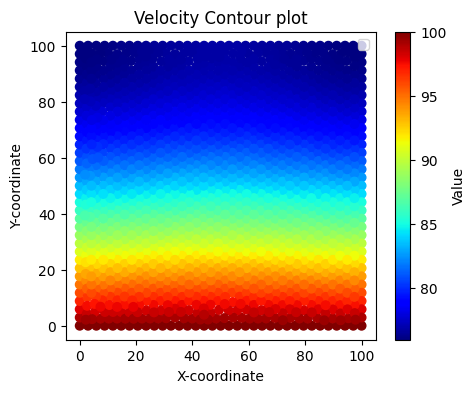

In [29]:
n = int(temp.shape[0])
print(np.max(temp[n-1,:]))
plt.figure(figsize=(5,4))
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Velocity Contour plot')
scatter = plt.scatter(msh.coords[:, 0], msh.coords[:, 1], c=temp[n-1,:], cmap='jet', s=38, edgecolor=None)
plt.legend()
plt.colorbar(scatter, label='Value')
plt.show()

In [22]:
np.min(temp[n-1,:])

75.96705468337046